# Importing Libraries 

In [1]:
import numpy as np
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont
from PIL import Image as pImage
from IPython.display import Image
%matplotlib inline


# Calibration of camera

In [2]:
def camera_calib(images,nx,ny):
    
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Store object points and image points
    objpoints = [] 
    imgpoints = [] 
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        
        if ret == True:
            # Add object points, image points
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret) 
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

In [3]:
images = glob.glob('camera_cal/calibration*.jpg')
nx,ny = 9,6
ret, mtx, dist, rvecs, tvecs = camera_calib(images,nx,ny)

Text(0.5,1,'Original')

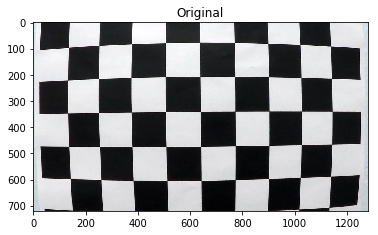

In [5]:
cal_img = cv2.imread('camera_cal/calibration1.jpg')
plt.imshow(cal_img)
plt.title('Original')

Text(0.5,1,'Undistorted')

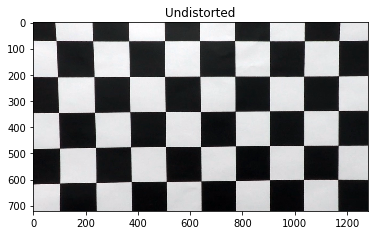

In [6]:
undist_cal = cv2.undistort(cal_img, mtx, dist, None, mtx)
plt.imshow(undist_cal)
plt.title('Undistorted')


# Testing Calibration camera matrix 

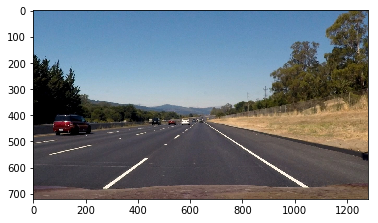

In [7]:
# Test image
image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

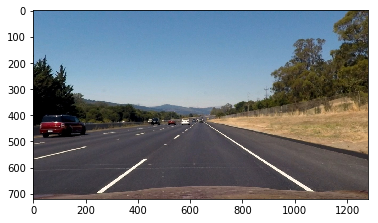

In [86]:
# Undistorted
undist = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(undist)
plt.savefig('test1.jpg')

# Color gradient computations

In [9]:
def color_filter(undist):
    # Convert to HLS
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    thresh = (200, 255)
    white = np.zeros_like(L)
    white[(L > thresh[0]) & (L <= thresh[1])] = 1
    hue_thresh = (14, 24) 
    sat_thresh = (110, 255)
    yellow = np.zeros_like(H)
    yellow[(H > hue_thresh[0]) & (H <= hue_thresh[1]) & (S > sat_thresh[0]) & (S <= sat_thresh[1])] = 1

    edges = np.zeros_like(white) #combined binary
    edges[(white == 1) | (yellow == 1)] = 255
    
    # Mask
    mask = np.dstack((edges,edges,edges))
    masked_color_edges = cv2.bitwise_and(undist, mask)
    return masked_color_edges

In [10]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
  
    thresh_min = thresh[0]
    thresh_max = thresh[1]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur_gray = cv2.GaussianBlur(gray,(sobel_kernel, sobel_kernel),0)
    
    sobelx = cv2.Sobel(blur_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(blur_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)

    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh_min) & (grad_dir <= thresh_max)] = 255
    return np.uint8(binary_output)

def canny(img,kernel_size=5, low_threshold=80, high_threshold=240):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    canny_edges =  cv2.Canny(blur_gray, low_threshold, high_threshold)
    return canny_edges

In [12]:
def region_of_interest(img, vertices):
 
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [16]:
masked_color_edges = color_filter(undist)
masked_color_edges = color_filter(undist)
dir_binary = dir_threshold(masked_color_edges, sobel_kernel=5, thresh=(0.8, 1.5))
canny_edges = canny(masked_color_edges,kernel_size=9, low_threshold=25, high_threshold=50)
edges=dir_binary


(720, 1280)


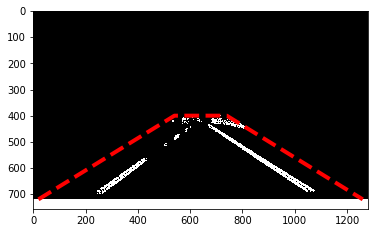

In [87]:
imshape = edges.shape
print(imshape)
# Define polygon vertices for the mask
vertices = np.array([[(20,imshape[0]),(imshape[1]//2-100, imshape[0]//2+40), 
                      (imshape[1]//2+100, imshape[0]//2+40), (imshape[1]-20,imshape[0])]],
                        dtype=np.int32)

# Filter image area with region of interest mask
masked_edges = region_of_interest(edges, vertices)

# print mask over the image
x = np.array(vertices[0][:,0])
y = np.array(vertices[0][:,1])
plt.figure()
plt.imshow(masked_edges,cmap='gray')
plt.plot(x,y,'r--', lw=4)
plt.show()
plt.savefig('binary_combo_example.jpg')

# Perspective transform

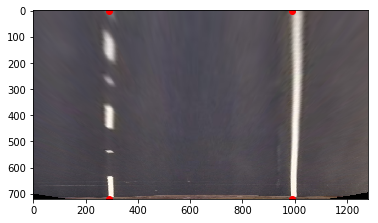

In [97]:
ym_per_pix = 30/720 
xm_per_pix = 3.7/700

img = undist
img_size=(img.shape[1],img.shape[0])
xoffset = 290
yoffset = 0
# Source and destination
src = np.float32([[595,450],[686,450],[1100,720],[208,720]])
dst = np.float32([[xoffset,0],[img_size[0]-1-xoffset,0],
                  [img_size[0]-1-xoffset,img_size[1]-1],
                  [xoffset,img_size[1]-1]])

# Get the perspective transform matrix and its inverse
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undist, M, img_size)
plt.imshow(warped, cmap='gray')
plt.plot(dst[:,0],dst[:,1],'ro') #reference dots
plt.show()
plt.savefig('warped_straight_lines.jpg')

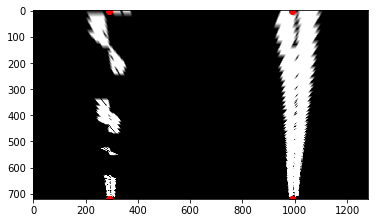

In [98]:
warped = cv2.warpPerspective(masked_edges, M, img_size)
plt.imshow(warped, cmap='gray') #,cmap='gray'
plt.plot(dst[:,0],dst[:,1],'ro')
plt.show()

In [99]:
def find_lane_pixels(binary_warped,plot=False):
 
    # Histogram
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    
    # Choose the number of sliding windows
    nwindows = 9
    
    margin = 140 
    minpix = 60

    
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if plot:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                          (win_xleft_high, win_y_high), (0, 255, 0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low),
                          (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)


        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [100]:
def look_ahead_filter(binary_warped,left_line,right_line,plot=False):

    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) 
    
    
    nwindows = 9
    margin = 120
    minpix = 30

   
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_windows = np.flip(left_line.bestx)
    rightx_windows = np.flip(right_line.bestx)
    leftx_current = leftx_windows[0]
    rightx_current = rightx_windows[0]

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    #flag to represent if line.bestx is still good
    centered = True
    # Step through the windows one by one
    for window in range(nwindows):
        
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if plot:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                          (win_xleft_high, win_y_high), (0, 255, 0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low),
                          (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        ymax=binary_warped.shape[0]-1
        # If you found < minpix pixels, recenter next window on their histogram
        if (len(good_left_inds) < minpix) or (len(good_right_inds) < minpix):
            current_height=max(0,ymax-window_height*window)
            histogram = np.sum(binary_warped[max(current_height-100,0):current_height, :], axis=0)
            midpoint = np.int(histogram.shape[0] // 2)
            leftx_current = np.argmax(histogram[:midpoint])
            rightx_current = np.argmax(histogram[midpoint:]) + midpoint
            centered = False
        # else use previous windows' centers    
        elif (window+1 < nwindows) and centered:
            leftx_current = leftx_windows[window_height*(window+1)]
            rightx_current = rightx_windows[window_height*(window+1)]
        #else get the mean of good inds
        else:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [103]:
def fit_polynomial(binary_warped, left_line=None,right_line=None, plot=False):

    if plot:
        plt.figure()
    if left_line and right_line:
        if (left_line.bestx is not None) and (right_line.bestx is not None):
            leftx, lefty, rightx, righty, out_img = look_ahead_filter(binary_warped,
                                                                      left_line=left_line,
                                                                      right_line=right_line,
                                                                      plot=plot)
        else:
            leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped,plot=plot)
    else:
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped,plot=plot)
    
    # Conversion
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty ** 2 + 1 * ploty
        right_fitx = 1 * ploty ** 2 + 1 * ploty
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if plot:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img)
        plt.show()
        plt.savefig('color_fit_lines.jpg')
    return out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx

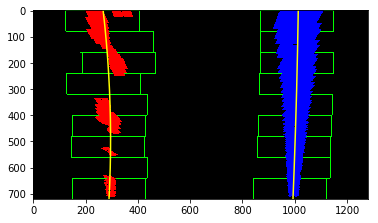

In [104]:
out_img, ploty, left_fit_cr, right_fit_cr, left_fitx, right_fitx = fit_polynomial(warped,plot=True)

In [68]:
def search_around_poly(binary_warped):

        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Get left_fit, right_fit
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

       
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [55, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 55]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

       
        
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)


        ## End visualization steps ##
        return result, left_fitx, right_fitx, left_fit, right_fit, ploty

# Radius of curvature

In [69]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
   
    # Conversions in x and y from pixels space to real world
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700
    y_eval = np.max(ploty)*ym_per_pix
    # Calculation of curvature
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**(3/2))/np.abs(2*left_fit_cr[0])
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**(3/2))/np.abs(2*right_fit_cr[0])

    return left_curverad, right_curverad
left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)
print(left_curverad, 'm', right_curverad, 'm')

1408.81760919 m 9193.26058612 m


In [70]:
def draw_lane(warped,undist,ploty,left_fitx,right_fitx,Minv):
   
   
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
   
    
    
    return result

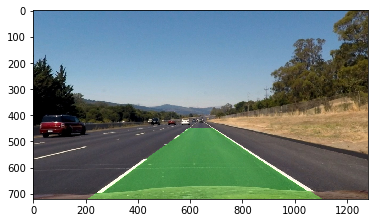

In [105]:
result = draw_lane(warped,undist,ploty,left_fitx,right_fitx,Minv)
plt.imshow(result)
plt.savefig('example_output.jpg')

# Pipeline for images

In [72]:
def pipeline(img, mtx, dist):
  
  
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.undistort(image, mtx, dist, None, mtx)
    plt.figure()
    plt.imshow(image)
    plt.title("Undistorted image")
    plt.show()
    
    # filter by white and yellow colors in HLS color space
    masked_color_edges = color_filter(image)
    plt.figure()
    plt.imshow(masked_color_edges)
    plt.title("Color filters")
    plt.show()
    
    # Detect edges with gradient
    edges = dir_threshold(masked_color_edges, sobel_kernel=5, thresh=(0.8, 1.5))
    plt.figure()
    plt.imshow(edges, cmap='Greys_r')
    plt.title("Detected edges")
    plt.show()
    
    # ROI
    imshape = edges.shape
    vertices = np.array([[(20,imshape[0]),(imshape[1]//2-100, imshape[0]//2+40),
                        (imshape[1]//2+100, imshape[0]//2+40),
                        (imshape[1]-20,imshape[0])]],
                        dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    plt.figure()
    plt.imshow( masked_edges, cmap='gray')
    plt.title("ROI mask")
    plt.show()
    
    # Perspective Transform
    img = masked_edges
    img_size=(img.shape[1],img.shape[0])
    xoffset = 290
    src = np.float32([[595,450],[686,450],[1100,720],[208,720]])
    dst = np.float32([[xoffset,0],[img_size[0]-1-xoffset,0],
                      [img_size[0]-1-xoffset,img_size[1]-1],
                      [xoffset,img_size[1]-1]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(masked_edges, M, img_size)
    plt.figure()
    plt.imshow(warped, cmap='gray')
    plt.title("Warped image")
    plt.show()
    
    # Curvature
    #out_img,ploty,left_fit_cr,right_fit_cr,left_fitx,right_fitx = fit_polynomial(warped,plot=True)
    out_img,left_fitx,right_fitx,left_fit_cr,right_fit_cr,ploty = search_around_poly(warped)
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)
    print(left_curverad, 'm', right_curverad, 'm')    

    mean_curverad = int((left_curverad + right_curverad)/2)
    
   
    # Draw Lane
    result = draw_lane(warped,image,ploty,left_fitx,right_fitx,Minv)
     
    offset_x = (1280/2) - (np.mean(left_fit_cr) + np.mean(right_fit_cr))/2
    suffix = "to right" if offset_x > 0 else "to left"
    offset_x_meter = offset_x * 3.7/700
    pos = abs(offset_x_meter)
    
    cv2.putText(result, 'Radius of Curvature = %.0f m ' % (mean_curverad), (50, 70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 230, 230), 3)
    cv2.putText(result, 'Position= {0:.2f} m '.format(pos) +suffix, (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 230, 230), 3)
    plt.figure()
    plt.imshow(result)
    plt.title("Detected Lane")
    plt.show()

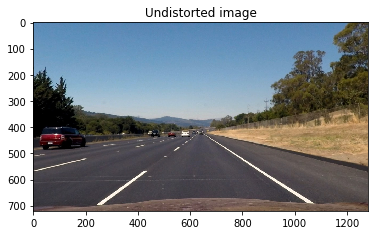

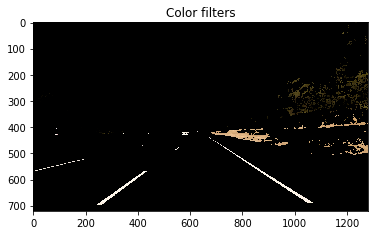

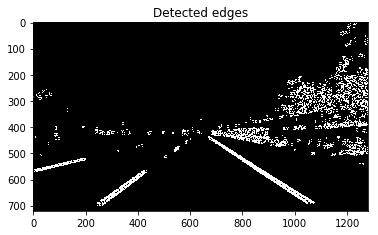

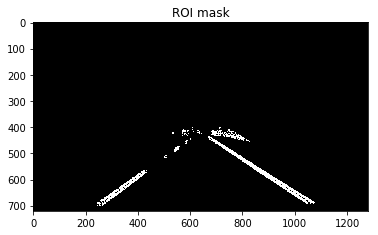

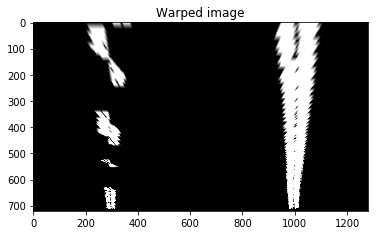

3631.54460352 m 27999.3748591 m


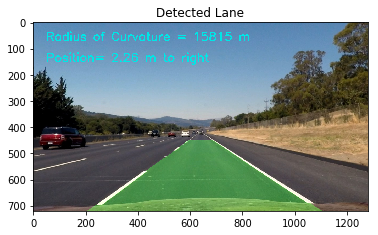

In [73]:
# Test images evaluation
test_image = cv2.imread('test_images/straight_lines2.jpg')
pipeline(test_image, mtx, dist)
IMG_PATH = 'test_images/'

# Test Video 

In [74]:
from moviepy.editor import VideoFileClip,ImageSequenceClip
from IPython.display import HTML

In [75]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        # values of the last n coefficients
        self.recent_fits = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.recent_radius = []
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None

In [82]:
def pipeline(img):
    img_name=None
    n=10
    nmax=100
    rad_max=1e4
    if img_name:
        print('Processing %s' % img_name)
    # Prepare image
    # video frame is RGB already, so this time we only remove distortions
    image = cv2.undistort(img, mtx, dist, None, mtx)
    
    masked_color_edges = color_filter(image)
    
    # apply gradient direction edge detector
    edges = dir_threshold(masked_color_edges, sobel_kernel=5, thresh=(0.8, 1.5))
    
    
    imshape = edges.shape
    vertices = np.array([[(20,imshape[0]),(imshape[1]//2-100, imshape[0]//2+40),
                        (imshape[1]//2+100, imshape[0]//2+40),
                        (imshape[1]-20,imshape[0])]],
                        dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    try :
        # Perspective Transform
        img = masked_edges
        img_size=(img.shape[1],img.shape[0])
        xoffset = 290
        src = np.float32([[595,450],[686,450],[1100,720],[208,720]])
        dst = np.float32([[xoffset,0],[img_size[0]-1-xoffset,0],
                          [img_size[0]-1-xoffset,img_size[1]-1],
                          [xoffset,img_size[1]-1]])

        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(masked_edges, M, img_size)

         # Curvature
        #out_img,ploty,left_fit_cr,right_fit_cr,left_fitx,right_fitx = fit_polynominal(warped)
        out_img,left_fitx,right_fitx,left_fit_cr,right_fit_cr,ploty = search_around_poly(warped)
        left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr)
        mean_curverad = int((left_curverad + right_curverad)/2)

        line_detected = True
         # Draw Lane
        result = draw_lane(warped,image,ploty,left_fitx,right_fitx,Minv)
        offset_x = (1280/2) - (np.mean(left_fit_cr) + np.mean(right_fit_cr))/2
        suffix = "to right" if offset_x > 0 else "to left"
        offset_x_meter = offset_x * 3.7/700
        pos = abs(offset_x_meter)
    
        cv2.putText(result, 'Radius of Curvature = %.0f m ' % (mean_curverad), (50, 70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 230, 230), 3)
        cv2.putText(result, 'Position= {0:.2f} m '.format(pos) +suffix, (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 230, 230), 3)
        return result
    except:
        # Draw Lane
        result = draw_lane(warped,image,ploty,left_fitx,right_fitx,Minv)

        return img

In [83]:
right_line = Line()
left_line = Line()
#outfile = './project_video.mp4'
outfile = './output_video/project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video ./output_video/project_video_result.mp4
[MoviePy] Writing video ./output_video/project_video_result.mp4


100%|█████████▉| 1260/1261 [05:36<00:00,  3.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/project_video_result.mp4 

CPU times: user 3min 9s, sys: 25.1 s, total: 3min 34s
Wall time: 5min 39s


In [84]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outfile))